# Building user-based recommendation model for Amazon

#### Importing Library

In [1]:
import pandas as pd
import numpy  as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity

######  Loading Data set

In [2]:
df = pd.read_csv("Amazon - Movies and TV Ratings.csv", index_col=0)

In [3]:
df.head()

,Movie1,Movie2,Movie3,Movie4,Movie5,Movie6,Movie7,Movie8,Movie9,Movie10,...,Movie197,Movie198,Movie199,Movie200,Movie201,Movie202,Movie203,Movie204,Movie205,Movie206
user_id,,,,,,,,,,,,,,,,,,,,,
A3R5OBKS7OM2IR,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AH3QC2PC1VTGP,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3LKP6WPMP9UKX,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVIY68KEPQ5ZD,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CV1WROP5KTTW,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Visualize missing values (NaN) values.

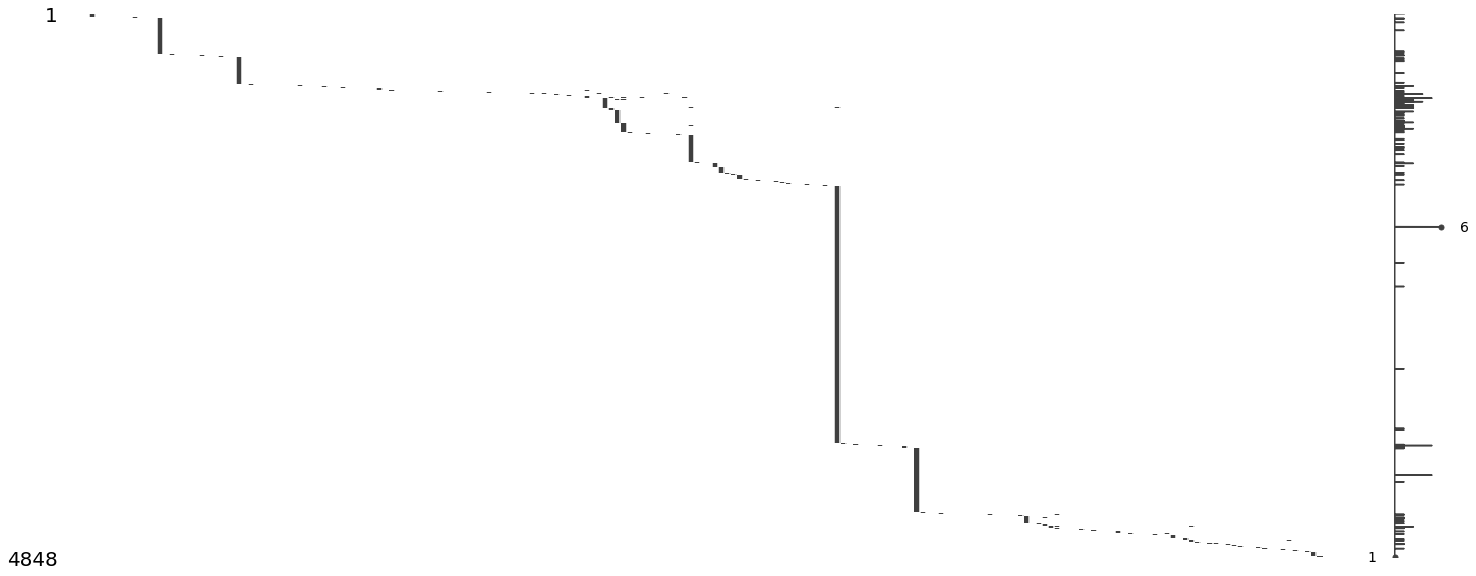

In [4]:
msno.matrix(df)

In [5]:
dataFrame = df.stack().reset_index()
dataFrame.columns = ['User_ID','Movie','Rating']
dataFrame.head()

,User_ID,Movie,Rating
0,A3R5OBKS7OM2IR,Movie1,5.0
1,A3R5OBKS7OM2IR,Movie2,5.0
2,AH3QC2PC1VTGP,Movie3,2.0
3,A3LKP6WPMP9UKX,Movie4,5.0
4,AVIY68KEPQ5ZD,Movie4,5.0


In [6]:
dataFrame.describe()

,Rating
count,5000.000000
mean,4.385600
std,1.199667
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
dataFrame_describe = dataFrame.groupby('Movie')['Rating'].describe()
dataFrame_mean = dataFrame_describe['mean']
dataFrame_mean

Movie
Movie1      5.000000
Movie10     5.000000
Movie100    4.000000
Movie101    5.000000
Movie102    4.000000
              ...   
Movie95     3.333333
Movie96     5.000000
Movie97     4.800000
Movie98     5.000000
Movie99     4.000000
Name: mean, Length: 206, dtype: float64

In [8]:
dataFrame_count = dataFrame_describe['count']
dataFrame_count 

Movie
Movie1      1.0
Movie10     1.0
Movie100    1.0
Movie101    5.0
Movie102    2.0
           ... 
Movie95     6.0
Movie96     3.0
Movie97     5.0
Movie98     1.0
Movie99     2.0
Name: count, Length: 206, dtype: float64

In [9]:
dataFrame_count_mean = pd.concat([dataFrame_count, dataFrame_mean], axis = 1)
dataFrame_count_mean.reset_index()

,Movie,count,mean
0,Movie1,1.0,5.000000
1,Movie10,1.0,5.000000
2,Movie100,1.0,4.000000
3,Movie101,5.0,5.000000
4,Movie102,2.0,4.000000
...,...,...,...
201,Movie95,6.0,3.333333
202,Movie96,3.0,5.000000
203,Movie97,5.0,4.800000
204,Movie98,1.0,5.000000


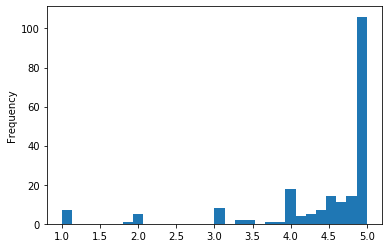

In [10]:
dataFrame_count_mean['mean'].plot(bins=30, kind='hist') 

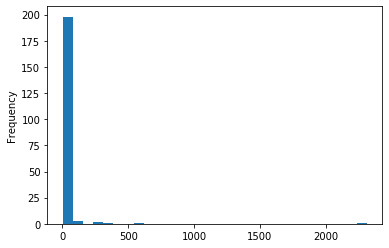

In [11]:
dataFrame_count_mean['count'].plot(bins=30, kind='hist') 

In [12]:
dataFrame_count_mean.sort_values('count', ascending = False).head(100)

,count,mean
Movie,,
Movie127,2313.0,4.111976
Movie140,578.0,4.833910
Movie16,320.0,4.518750
Movie103,272.0,4.562500
Movie29,243.0,4.806584
...,...,...
Movie4,2.0,5.000000
Movie32,2.0,4.500000
Movie93,2.0,5.000000


##### Top 5 movies with the maximum ratings.

In [13]:
dataFrame_count_mean.sort_values('mean', ascending = False).head(5)

,count,mean
Movie,,
Movie1,1.0,5.0
Movie57,1.0,5.0
Movie186,9.0,5.0
Movie183,1.0,5.0
Movie181,2.0,5.0


##### Top 5 movies with the least audience.

In [14]:
dataFrame_count_mean.sort_values('mean', ascending = True).head(5)

,count,mean
Movie,,
Movie69,1.0,1.0
Movie45,1.0,1.0
Movie144,1.0,1.0
Movie58,1.0,1.0
Movie154,1.0,1.0


In [15]:
df = df.fillna(0)

### Recommendation Model

In [16]:
def standardization(row):
    new_row_value = (row -row.mean())/(row.max()-row.min())
    return new_row_value

In [17]:
standardized_data_set = df.apply(standardization)

We will use Cosine similarity is a metric used to measure how similar the ratings are irrespective of their value.

In [18]:
simalrity_score = cosine_similarity(standardized_data_set.T)

In [19]:
simlarity_dataFrame =pd.DataFrame(simalrity_score,index=df.columns, columns=df.columns)
simlarity_dataFrame

,Movie1,Movie2,Movie3,Movie4,Movie5,Movie6,Movie7,Movie8,Movie9,Movie10,...,Movie197,Movie198,Movie199,Movie200,Movie201,Movie202,Movie203,Movie204,Movie205,Movie206
Movie1,1.000000,1.000000,-0.000206,-0.000292,-0.001049,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,...,-0.000430,-0.000292,-0.000206,-0.000581,-0.000349,-0.000478,-0.000206,-0.000559,-0.001202,-0.000744
Movie2,1.000000,1.000000,-0.000206,-0.000292,-0.001049,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,...,-0.000430,-0.000292,-0.000206,-0.000581,-0.000349,-0.000478,-0.000206,-0.000559,-0.001202,-0.000744
Movie3,-0.000206,-0.000206,1.000000,-0.000292,-0.001049,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,...,-0.000430,-0.000292,-0.000206,-0.000581,-0.000349,-0.000478,-0.000206,-0.000559,-0.001202,-0.000744
Movie4,-0.000292,-0.000292,-0.000292,1.000000,-0.001483,-0.000292,-0.000292,-0.000292,-0.000292,-0.000292,...,-0.000609,-0.000413,-0.000292,-0.000821,-0.000494,-0.000676,-0.000292,-0.000791,-0.001701,-0.001052
Movie5,-0.001049,-0.001049,-0.001049,-0.001483,1.000000,-0.001049,-0.001049,-0.001049,-0.001049,-0.001049,...,-0.002188,-0.001483,-0.001049,-0.002952,-0.001775,-0.002430,-0.001049,-0.002842,-0.006111,-0.003780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Movie202,-0.000478,-0.000478,-0.000478,-0.000676,-0.002430,-0.000478,-0.000478,-0.000478,-0.000478,-0.000478,...,-0.000997,-0.000676,-0.000478,-0.001346,-0.000809,1.000000,-0.000478,-0.001296,-0.002786,-0.001723
Movie203,-0.000206,-0.000206,-0.000206,-0.000292,-0.001049,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,...,-0.000430,-0.000292,-0.000206,-0.000581,-0.000349,-0.000478,1.000000,-0.000559,-0.001202,-0.000744
Movie204,-0.000559,-0.000559,-0.000559,-0.000791,-0.002842,-0.000559,-0.000559,-0.000559,-0.000559,-0.000559,...,-0.001167,-0.000791,-0.000559,-0.001574,-0.000947,-0.001296,-0.000559,1.000000,-0.003258,-0.002016
Movie205,-0.001202,-0.001202,-0.001202,-0.001701,-0.006111,-0.001202,-0.001202,-0.001202,-0.001202,-0.001202,...,-0.002508,-0.001701,-0.001202,-0.003385,-0.002035,-0.002786,-0.001202,-0.003258,1.000000,-0.004334


In [20]:
def recommendation(movie, rating):    
    """
    This function will make recommendations only based on how 
    users rated products in the past, not based on anything about
    the products themselves.This function will take the movie and
    the rating based that it will give a recommendation.  
    """
    similar_value = simlarity_dataFrame[movie]*(rating)
    similar_value  =  similar_value.sort_values(ascending = False)
    return  similar_value

#### Testing 

In [21]:
print(recommendation("Movie1", 5))

Movie1      5.000000
Movie2      5.000000
Movie195   -0.001032
Movie203   -0.001032
Movie171   -0.001032
              ...   
Movie29    -0.016339
Movie103   -0.017049
Movie16    -0.018784
Movie140   -0.026189
Movie127   -0.061902
Name: Movie1, Length: 206, dtype: float64


In [22]:
print(recommendation("Movie1", 1))

Movie1      1.000000
Movie2      1.000000
Movie195   -0.000206
Movie203   -0.000206
Movie171   -0.000206
              ...   
Movie29    -0.003268
Movie103   -0.003410
Movie16    -0.003757
Movie140   -0.005238
Movie127   -0.012380
Name: Movie1, Length: 206, dtype: float64
